# 2 - Algorithm Design

In [1]:
import pandas as pd
import numpy as np

from tqdm import tqdm_notebook,tnrange,tqdm_pandas,tqdm
tqdm.pandas()

import os
import cPickle as pickle

import datetime as dt

import ipywidgets as widgets


import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)
#notify if cell is finished for cells taking longer than 30 seconds
%autonotify -a 30

<IPython.core.display.Javascript object>

## setup plotting for later

In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

full_column_width = 1400
out_set = 2040
screen_width = 2500

medium_image_size = screen_width

aspect_ratio = 9/16
my_dpi = 96

width = medium_image_size / my_dpi
height = width * aspect_ratio
size = (width, height)


if medium_image_size == full_column_width:
    small_text = 14
    medium_text = 16
    big_text = 260
elif medium_image_size == out_set:
    small_text = 16
    medium_text = 18
    big_text = 30
elif medium_image_size == screen_width:
    small_text = 14
    medium_text = 16
    big_text = 26
else:
    small_text = 14
    medium_text = 16
    big_text = 26
    

    
plt.style.use("ggplot")
plt.figure(figsize=size, dpi=my_dpi)
plt.rcParams['font.family'] = 'Charter'
plt.rcParams['font.serif'] = 'Charter'
plt.rcParams['font.monospace'] = 'Menlo'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = medium_text
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = small_text
plt.rcParams['ytick.labelsize'] = small_text
plt.rcParams['legend.fontsize'] = medium_text
plt.rcParams['figure.titlesize'] = big_text

### Path to your urinal-data-28-nov_clean _pickle_ file

In [3]:
pickle_full = "Data Files/urinal-data-28-nov_clean.p"

### Load Data

In [4]:
#---------- read in pickle----------   
if os.path.isfile(pickle_full):
    print("loading pickle")
    df = pd.read_pickle(pickle_full)
   
else:
    raise Exception("Did you run 1 - Raw Data Visualisation?")

loading pickle


<IPython.core.display.Javascript object>

we want indexes not, timestamps, as our time data is only recorded to the nearest second (yet we have a sampling rate of 10 frames/second)

In [5]:
df.reset_index(inplace=True)

In [6]:
df.sample(2)

,time,P0,P1,P2,P3,P4,P5,P6,P7,P8,...,P54,P55,P56,P57,P58,P59,P60,P61,P62,P63
1734316,2017-11-25 23:33:10,23.00,23.25,22.0,22.0,23.25,23.00,23.25,22.50,21.50,...,22.25,23.5,22.75,23.50,23.00,22.75,24.0,23.25,22.50,23.5
3466022,2017-11-28 06:01:54,19.75,22.75,21.0,22.5,22.25,22.75,21.75,21.75,22.25,...,22.25,21.5,22.00,22.75,23.25,22.50,23.0,23.25,21.25,22.0


## Adaptive Threshold
In _1- Raw Data Visualisation_ we saw how noisy our data is. 
With some additional testing, it's pretty clear simply looking for pixels above a set temperature is not sufficient, the ambient air temperature just varies too [much](https://www.sciencedirect.com/science/article/pii/S0360132396000340)!

<img src="Images/layout_sections.png" alt="grideye camera view" width="350" height="350" align="left">So: 
- We want to find a warm body in the of mess pixels. 
- We have a pretty good idea of where the warm body will appear. 
- We have an area where no person will be (the empty space)




These [researchers](http://www.scirp.org/jouRNAl/PaperInformation.aspx?PaperID=74726) achieved 97% accuracy finding a person with the Grid-EYE.  
By adapting their algorithm, we created an adaptive threshold algorithm for determining a urinal __"stay"__ which goes something like:

1. get background temperature (Empty Space) ($T_b$)
2. Calculate mean of highest three temperatures for each section  ($T_m$)
3. Compare $T_b$ to $T_m$ ($T_m - T_b > threshold$) and greater than an absolute temperature ($T_{abs}$) 
4. Determine a "__stay__" by thresholding the time

### Grab the Urinal Section

We first create a "mask" which contains a list of column names corresponding to the Urinal section  
In this case we ignore the top 2 rows, as no one in the office is above 7 foot!

In [7]:
height = 6
n = 8
width_left = 2
width_middle = 3
width_right = 3
bottom_trim = 0

left_mask   = []
middle_mask = []
right_mask  = []
for y in range(n-height,n-bottom_trim):
    # LEFT
    for x in range(width_left):
        left_mask.append(x+y*n) 
    # MIDDLE
    for x in range(width_middle):
         middle_mask.append(x+y*n+width_left) 
    # RIGHT
    for x in range(width_right):
         right_mask.append(x+y*n+width_left+width_middle) 

left_mask = ["P"+str(x) for x in left_mask]  
middle_mask = ["P"+str(x) for x in middle_mask]  
right_mask = ["P"+str(x) for x in right_mask]  


### Grab the background temperature ($T_b$)
Assuming no person (or hot object) will loiter near the roof,  
we take the background temperature values as the mean of top 2 rows (per section<sup>1</sup>)  
___
<sup>1</sup><sub>Per section, as there are AC vents above the left and right urinals and not the middle, therefore the temperature is generally higher in the middle.</sub>

In [8]:
height = 6 # top 2 rows
n = 8
width_left = 2
width_middle = 3
width_right = 3

left_top   = []
middle_top = []
right_top  = []
for y in range(0,n-height):
    # LEFT
    for x in range(width_left):
        left_top.append(x+y*n) 
    # MIDDLE
    for x in range(width_middle):
         middle_top.append(x+y*n+width_left) 
    # RIGHT
    for x in range(width_right):
         right_top.append(x+y*n+width_left+width_middle) 

left_top = ["P"+str(x) for x in left_top]  
middle_top = ["P"+str(x) for x in middle_top]  
right_top = ["P"+str(x) for x in right_top]  

df[middle_top].sample(10)

,P2,P3,P4,P10,P11,P12
3506906,22.25,22.00,22.00,23.00,22.75,22.25
1205211,22.75,23.25,23.00,22.50,23.50,21.75
3524789,22.00,22.00,22.00,21.75,23.00,22.25
2751438,21.00,22.25,23.25,23.00,22.75,22.00
575367,21.50,21.75,22.00,22.75,23.25,21.75
2198707,23.00,23.75,23.75,23.00,23.75,23.00
3105368,23.25,22.25,22.00,23.75,23.50,22.50
480227,22.25,21.75,22.25,22.25,23.00,22.50
1196427,22.75,23.25,23.75,23.50,23.50,22.50
2450252,22.75,22.25,23.00,23.50,23.25,22.75


### Calculate the Background temperature ($T_b$)
We take the background temperature every minute, therefore making sure long-term changes in ambient temperature are considered 

In [9]:
window = 600 # 1 minute window for background temp

left_background = []
middle_background = []
right_background = []

for t in tnrange(window/2,len(df),window):  
    left_background.append(df.loc[t-window/2:t+window/2,:][left_top].mean().mean())
    middle_background.append(df.loc[t-window/2:t+window/2,:][middle_top].mean().mean())
    right_background.append(df.loc[t-window/2:t+window/2,:][right_top].mean().mean())



HBox(children=(IntProgress(value=0, max=5901), HTML(value=u'')))

<IPython.core.display.Javascript object>

### Add minute to minute background temperatures ($T_b$) to dataframe
We also error check to make sure the columns are of equal length

In [10]:
left_background = [x for x in left_background for _ in range(window)]    
middle_background = [x for x in middle_background for _ in range(window)]    
right_background = [x for x in right_background for _ in range(window)]  

if len(left_background) > len(df):
    left_background = left_background[0:-(len(left_background) - len(df))]
    middle_background = middle_background[0:-(len(middle_background) - len(df))]
    right_background = right_background[0:-(len(right_background) - len(df))]
elif len(left_thresh) < len(df):    
    left_background.extend([left_background[-1]]*(len(df) - len(left_background)))
    middle_background.extend([middle_background[-1]]*(len(df) - len(middle_background)))
    right_background.extend([right_background[-1]]*(len(df) - len(right_background)))

if not (len(left_background) == len(middle_background) == len(right_background) == len(df)):
    raise AssertionError()

### Pickle Path

In [11]:
pickle_full = 'Data Files/compare_temps.p'

### Calculate the mean of the highest 3 temperatures per frame ($T_m$)
We find the highest three because this is approximately the number of pixels a person occupies in a frame.  
If we look at the mean of all pixels, the value calculated is generally too close to the background temperature.  
___
<sub>I've created my own function here as I found it to be significantly faster than using numpy's _argpartition_ or bottleneck's _partition_</sub>


In [12]:

if os.path.isfile(pickle_full):
    print("loading pickle")
    compare_temps = pd.read_pickle(pickle_full)
    left = compare_temps[compare_temps["position"] == 'left']
    middle = compare_temps[compare_temps["position"] == 'middle']
    right = compare_temps[compare_temps["position"] == 'right']
else:
    print("creating pickle...")
    print("this will take some time...")
    
    left  = df[left_mask].copy()
    middle = df[middle_mask].copy()
    right = df[right_mask].copy()
     
    # Define a function which calculates
    # the highest three numbers from a list 
    # and calculate their mean
    # O(n)
    def top_three_mean(numbers):
        count = 0
        m1 = m2 = m3 = float('-inf')
        for number in numbers:
            count += 1
            if number >= m3:
                if number >= m2:
                    if number >= m1:
                        m1, m2, m3 = number, m1, m2   
                    else:
                        m3 = m2
                        m2 = number
                else:
                    m3 = number

        tri_mean = np.mean((m1,m2,m3))          
        return tri_mean if count >= 2 else None

    # Apply top_three_mean to each urinal section
    left["mean3"] = left.progress_apply(top_three_mean,axis = 1)
    middle["mean3"] = middle.progress_apply(top_three_mean,axis = 1)
    right["mean3"] = right.progress_apply(top_three_mean,axis = 1)
    
    # assign the previous calculated background temperatures to each urinal section
    left["background_temp"] = left_background
    middle["background_temp"] = middle_background
    right["background_temp"] = right_background
    
    # specify the urinal section (this is more convenient for pickling)
    left["position"] = 'left'
    middle["position"] = 'middle'
    right["position"] = 'right'
    
    compare_temps = pd.concat([left.iloc[:,-3:],middle.iloc[:,-3:],right.iloc[:,-3:]],axis = 0)
    
    compare_temps.to_pickle(pickle_full)
    
    left = compare_temps[compare_temps["position"] == 'left']
    middle = compare_temps[compare_temps["position"] == 'middle']
    right = compare_temps[compare_temps["position"] == 'right']
    

loading pickle


### Compare background temperature to highest three temperatures
$T_m - T_b > T_{th}$ __AND__ $T_m > T_{abs}$  
These combined comparisons are converted to a boolean __1__ or __0__

$T_{Th}$ and $T_{abs}$ are determined from [Trofimova et. al.](http://www.scirp.org/jouRNAl/PaperInformation.aspx?PaperID=74726)

In [13]:
Tabs = 24.5
Tth = 1.5
df_temp_thresh = pd.DataFrame({"time":df["time"]})
df_temp_thresh["left"] = ((left["mean3"] - left["background_temp"] > Tth) & (left["mean3"] > Tabs)).astype(int)
df_temp_thresh["middle"] = ((middle["mean3"] - middle["background_temp"] > Tth) & (middle["mean3"] > Tabs)).astype(int)
df_temp_thresh["right"] = ((right["mean3"] - right["background_temp"] > Tth) & (right["mean3"] > Tabs)).astype(int)
df_temp_thresh.set_index("time",inplace=True)
df_temp_thresh.sample(5)

,left,middle,right
time,,,
2017-11-26 06:38:10,0,0,0
2017-11-25 09:10:07,0,0,0
2017-11-24 18:53:58,0,0,0
2017-11-23 17:52:31,0,0,0
2017-11-24 14:11:33,1,0,0


### Differentiate Binary values
Differentiating is a quick way of finding a state change,  
1 corresponds to a _walk in_, -1 corresponds to a _walk out_

In [14]:
df_temp_diff = df_temp_thresh.diff(axis=0)[1:]
df_temp_diff.reset_index(inplace=True)


### Remove all zeros
for the differentiated DataFrame zero corresponds to a state remaining the same.  
We only care about state changes!

In [15]:
df_temp_diff_redL =  pd.concat([df_temp_diff["left"][df_temp_diff["left"] != 0],df_temp_diff["time"][df_temp_diff["left"] != 0]],axis = 1)
df_temp_diff_redM = pd.concat([df_temp_diff["middle"][df_temp_diff["middle"] != 0],df_temp_diff["time"][df_temp_diff["middle"] != 0]],axis = 1)
df_temp_diff_redR = pd.concat([df_temp_diff["right"][df_temp_diff["right"] != 0],df_temp_diff["time"][df_temp_diff["right"] != 0]],axis = 1)

df_temp_diff_redL.columns = ["in_out","time"]
df_temp_diff_redM.columns = ["in_out","time"]
df_temp_diff_redR.columns = ["in_out","time"]

df_temp_diff_redR.head(5)

,in_out,time
130,1.0,2017-11-23 16:57:14
131,-1.0,2017-11-23 16:57:14
188,1.0,2017-11-23 16:57:21
189,-1.0,2017-11-23 16:57:21
225,1.0,2017-11-23 16:57:25


### Error Checking
Check that:
1. The data started with no person in frame
2. If a person walked in, they then walked out
3. The data ended with no person in frame

In [16]:
#check in_out always alternates-->it always does
prev = -1
test = df_temp_diff_redL
for i in tnrange(len(test)):
    
    curr = test["in_out"].iloc[i]
    if curr == prev:
        print(test["time"].iloc[i])
        raise AssertionError()
    prev = curr

    
assert df_temp_diff_redL["in_out"].sum() == 0 and df_temp_diff_redL["in_out"].iloc[-1] == -1 
assert df_temp_diff_redM["in_out"].sum() == 0 and df_temp_diff_redM["in_out"].iloc[-1] == -1
assert df_temp_diff_redR["in_out"].sum() == 0 and df_temp_diff_redR["in_out"].iloc[-1] == -1


HBox(children=(IntProgress(value=0, max=7984), HTML(value=u'')))

### Convert 1 to "in" and -1 to "out" for readability

In [17]:
def in_out(b):
    try:
        if int(b) == 1:
            return "in"
        elif int(b) == -1:
            return "out"
        else:
            return b
    except:
        return b
    
df_temp_diff_redL["in_out"]    = df_temp_diff_redL["in_out"].apply(in_out)
df_temp_diff_redM["in_out"]    = df_temp_diff_redM["in_out"].apply(in_out)
df_temp_diff_redR["in_out"]    = df_temp_diff_redR["in_out"].apply(in_out)


### Annotate the position

In [18]:
df_temp_diff_redL["Position"] = ["left" for x in range(len(df_temp_diff_redL))]
df_temp_diff_redM["Position"] = ["middle" for x in range(len(df_temp_diff_redM))]
df_temp_diff_redR["Position"] = ["right" for x in range(len(df_temp_diff_redR))]

### Concatenate positions for time sorting

In [19]:
rsv = df_temp_diff_redL
rsv = rsv.append(df_temp_diff_redM)
rsv = rsv.append(df_temp_diff_redR)

rsv.sort_index(inplace=True)
rsv.sample(5)

,in_out,time,Position
556392,in,2017-11-24 10:30:42,left
2360679,in,2017-11-26 19:14:52,left
1356333,out,2017-11-25 11:40:04,right
2856062,in,2017-11-27 10:50:32,middle
532773,out,2017-11-24 09:46:08,left


### Collect in and out times as indexes and time, and place them in a dictionary

In [20]:
# in and out are times, and inx and outx are the indexes
in_out_dict = {"left":{"in":[],"out":[],"inx":[],"outx":[]},"middle":{"in":[],"out":[],"inx":[],"outx":[]},
               "right":{"in":[],"out":[],"inx":[],"outx":[]}}

for t in tnrange(len(rsv)):
    in_out_dict[rsv["Position"].iloc[t]][rsv["in_out"].iloc[t]].append(rsv["time"].iloc[t])
    in_out_dict[rsv["Position"].iloc[t]][rsv["in_out"].iloc[t]+'x'].append(rsv.index[t])
    
    

HBox(children=(IntProgress(value=0, max=67246), HTML(value=u'')))

<IPython.core.display.Javascript object>

## Time Threshold
We now have a dictionary of all activity in our 3 urinal areas, timestamped.  
However, we still need to differentiate a person walking past the urinals (to take care of other business),   
and potentially remove any instantaneous temperature fluctuations  
(but hopefully our background temperature comparison took care of that).  

We call a person visiting the urinal, to relieve some pressure, a __stay__.  
A stay is defined as a person visisting the urinal longer than 10 seconds <sup>1</sup>.

___
<sup>1</sup> <sub> This was experimentally determined, and later verified by [this Ig Noble prize winning paper](http://www.pnas.org/content/111/33/11932?tab=ds), and two [Grideye](http://www.scirp.org/jouRNAl/PaperInformation.aspx?PaperID=74726) [specific](http://ieeexplore.ieee.org/document/6798925/) papers </sub>


In [21]:
from datetime import timedelta

# removes all non stays and sort into order of occurence
def removeNonStays(timeFilt):
    positions = ["left","middle","right"]
    unsorted_stays = pd.DataFrame()
    for position in positions:
        curr_stays = pd.concat([pd.DataFrame(in_out_dict[position]["in"]),pd.DataFrame(in_out_dict[position]["out"]),
                           pd.DataFrame(in_out_dict[position]["inx"]),pd.DataFrame(in_out_dict[position]["outx"])],axis=1)       
        curr_stays.columns = ["in","out","in_index","out_index"]
        curr_stays = curr_stays[curr_stays["out"] - curr_stays["in"]> timedelta(seconds=timeFilt )]
        curr_stays["length"] = curr_stays["out"] - curr_stays["in"]
        curr_stays["Position"] = position
        unsorted_stays = unsorted_stays.append(curr_stays)
        
        sorted_stays = unsorted_stays.sort_index()
        
    return sorted_stays



## Test time filter of 5 second

<IPython.core.display.Javascript object>


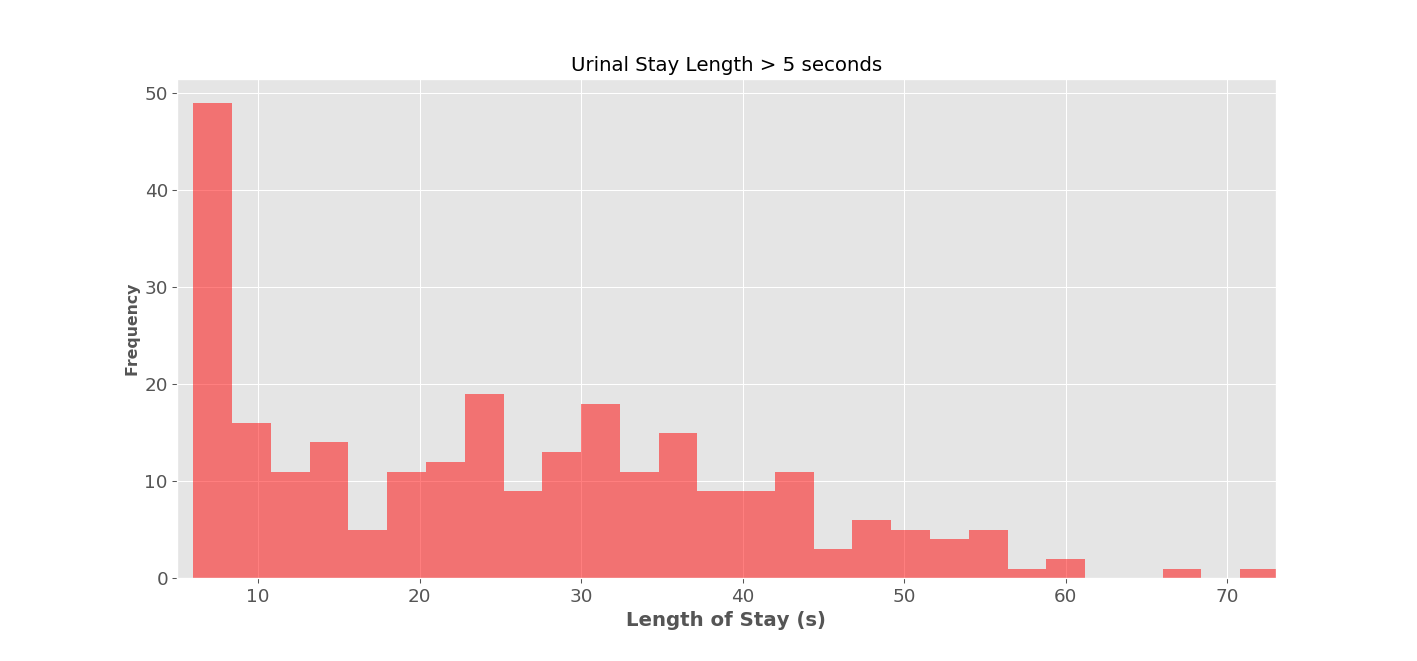

In [36]:
%matplotlib notebook
import matplotlib.pyplot as plt
from datetime import datetime
plt.rcParams['figure.figsize'] = (15,7)

timeFilter = 5 
sorted_stays = removeNonStays(timeFilter)
left_stays = sorted_stays[sorted_stays["Position"] == "left"]

fig, ax = plt.subplots()
Nbins = 30; transp = 0.5
left_hist = map(int,left_stays["length"].astype('timedelta64[s]'))
n, bins, patches = ax.hist(left_hist , bins=Nbins, facecolor='red', alpha=transp, histtype='bar')

plt.title("Urinal Stay Length > 5 seconds",fontsize=15)
plt.xlabel('Length of Stay (s)',fontsize=15)
plt.ylabel( 'Frequency')
ax.set_xlim([timeFilter,73]); 
fig.savefig('Images/Stays_greaterthan5_secs.png')

### Time filter for 10 seconds

In [22]:
timeFilter = 10
sorted_stays = removeNonStays(timeFilter)

removeNonStays(timeFilter).head()

,in,out,in_index,out_index,length,Position
23,2017-11-23 17:05:18,2017-11-23 17:05:52,2509,2814,00:00:34,left
28,2017-11-23 17:06:30,2017-11-23 17:07:12,3148,3520,00:00:42,left
37,2017-11-23 17:03:22,2017-11-23 17:03:48,1487,1719,00:00:26,right
44,2017-11-23 17:04:28,2017-11-23 17:05:15,2073,2486,00:00:47,right
69,2017-11-23 17:40:15,2017-11-23 17:40:52,21033,21364,00:00:37,left


In [23]:
pickle_full = "Data Files/sorted_stays.p"

In [24]:
if os.path.isfile(pickle_full):
    print("You've already pickled!")
   
else:
    sorted_stays.to_pickle(pickle_full)

You've already pickled!


### Plot the Mean Temperatures to visualise noise over whole period

In [25]:
df = df[df["time"].dt.day != 23]
temp_inst = df.iloc[:,1:].mean(axis=1)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


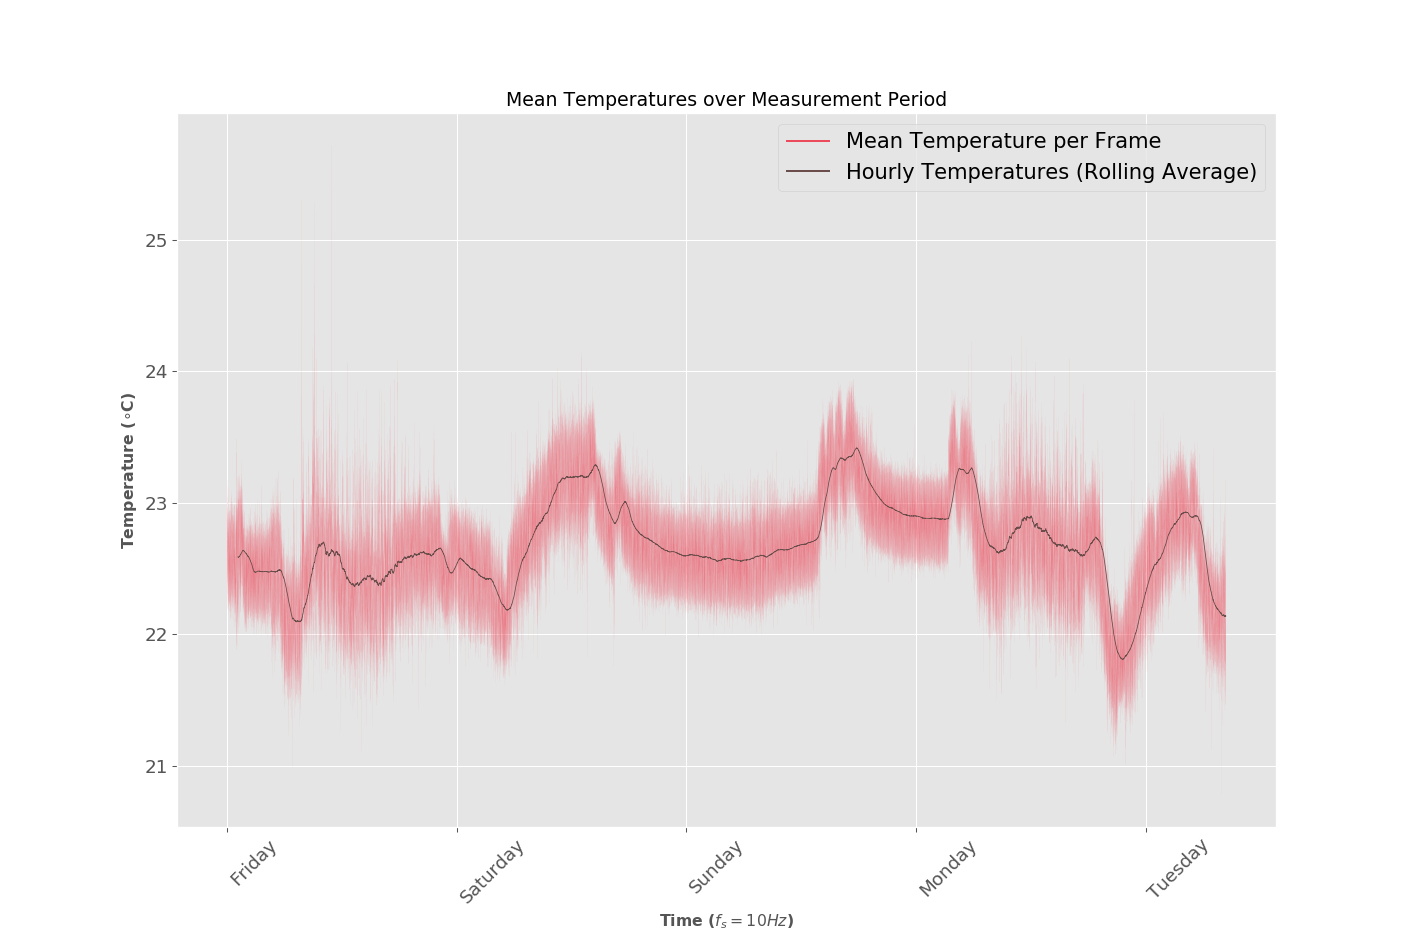

<IPython.core.display.Javascript object>

In [27]:

plt.rcParams['figure.figsize'] = (15,10)
fig, ax = plt.subplots()

plt.style.use('ggplot')
fs = 10
temp_insts, = plt.plot(temp_inst,linewidth=0.02, color='#ED495A')
temp_hour, = plt.plot(temp_inst.rolling(window=3600*fs).mean(),linewidth=0.6, color="#6A4C4A")
plt.xlabel('Time ($f_s = 10Hz$)');
plt.ylabel('Temperature ($\circ$C)');
plt.title('Mean Temperatures over Measurement Period')

xticks = df["time"][df["time"].dt.day != df["time"].dt.day.shift()].index

ax.set_xticks(xticks)
def dayint_to_12hour(day):
    return datetime.strptime("11 "+str(day-1), "%m %d").strftime("%A")

xlabels = map(dayint_to_12hour,df["time"].dt.day.unique());
ax.set_xticklabels(xlabels,rotation=45,ha='left');
temp_insts.set_label("Mean Temperature per Frame")
temp_hour.set_label("Hourly Temperatures (Rolling Average)")
leg = ax.legend();
leg.legendHandles[0].set_linewidth(1.5)
leg.legendHandles[1].set_linewidth(1.5)
fig.savefig('Images/Stays_per_Hour_day.png')

Now go to __3 - Data Analysis__ to see the Results